# population


In [34]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

In [35]:
n = 10
swiss = 0
######### GRID
# grid_size = 20
# N = grid_size**2
# coords = rng.grid_coordinates((grid_size, 2))


######### RANDOM
N = 500
coords = rng.random_coordinates((N, 2))
idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]

######### CLUSTRED
n_clusters = 4
cluster_std = 0.05
# N = 400
coords = rng.cluster_coordinates(n_clusters, cluster_std, (N, 2))


######### SWISS: https://docs.google.com/spreadsheets/d/10uYLsZpxRV5lUrsGfy3gI0RD4fAn8lIP/edit?usp=sharing&ouid=117333816980669142577&rtpof=true&sd=true
swiss = 1
swiss_df = pd.read_csv('/home/divar/projects/geometric-sampling/swiss.csv')
coords = swiss_df[['COORD_X', 'COORD_Y']].to_numpy()
swiss_df['AREA'] = swiss_df['AREA'].clip(lower=1, upper=20)
N = len(coords)




idx = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[idx]


In [36]:
######### EQUAL
probs = rng.equal_probabilities(n, N)


######### UNEQUAL
probs = np.sort(rng.unequal_probabilities(n, N))
probs = np.round(np.sort(rng.unequal_probabilities(n, N))[::-1], 3)
np.sum(probs == 0)  
q = 0.001
probs[probs == 0] = q
np.sum(probs)                                             
# if swiss == 1:
#     probs = inclusion_probabilities(swiss_df['AREA'].to_numpy(), n)


np.float64(10.016000000000002)

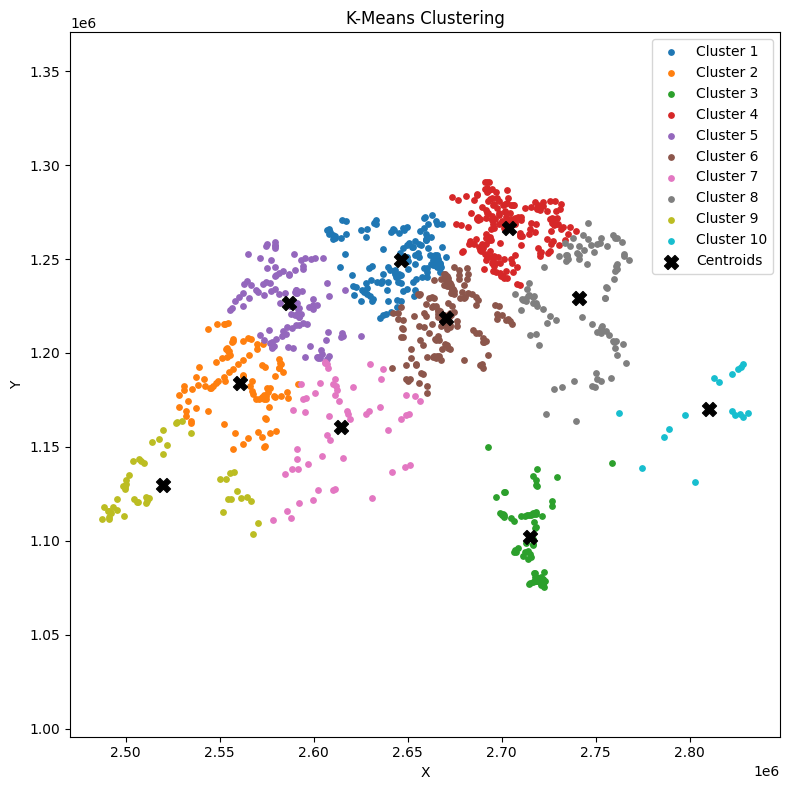

|   Cluster |   Size |   Sum of Probs |
|-----------|--------|----------------|
|         1 |    145 |          1.761 |
|         2 |     97 |          1.816 |
|         3 |     71 |          0.28  |
|         4 |    172 |          0.926 |
|         5 |    108 |          1.786 |
|         6 |    153 |          1.423 |
|         7 |     57 |          0.823 |
|         8 |     89 |          0.168 |
|         9 |     50 |          1.016 |
|        10 |     17 |          0.017 |


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Your code to get coords and probs above ...

n_clusters = n

# KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(coords)

# ---- Calculate cluster sizes and prob sums ----
cluster_sizes = np.zeros(n_clusters, dtype=int)
cluster_prob_sums = np.zeros(n_clusters, dtype=float)

for i in range(n_clusters):
    idx = (cluster_labels == i)
    cluster_sizes[i] = np.sum(idx)         # Number of points in cluster i
    cluster_prob_sums[i] = np.sum(probs[idx])  # Sum of probs for cluster i


# ---- Optional: plot as before ----
plt.figure(figsize=(8, 8))
for i in range(n_clusters):
    idx = cluster_labels == i
    plt.scatter(coords[idx, 0], coords[idx, 1], label=f'Cluster {i+1}', s=15)
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', s=100, marker='X', label='Centroids')

plt.legend()
plt.title('K-Means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.tight_layout()
plt.show()

from tabulate import tabulate

header = ["Cluster", "Size", "Sum of Probs"]
data = [
    [i+1, cluster_sizes[i], f"{cluster_prob_sums[i]:.4f}"] 
    for i in range(n_clusters)
]

print(tabulate(data, headers=header, tablefmt="github"))

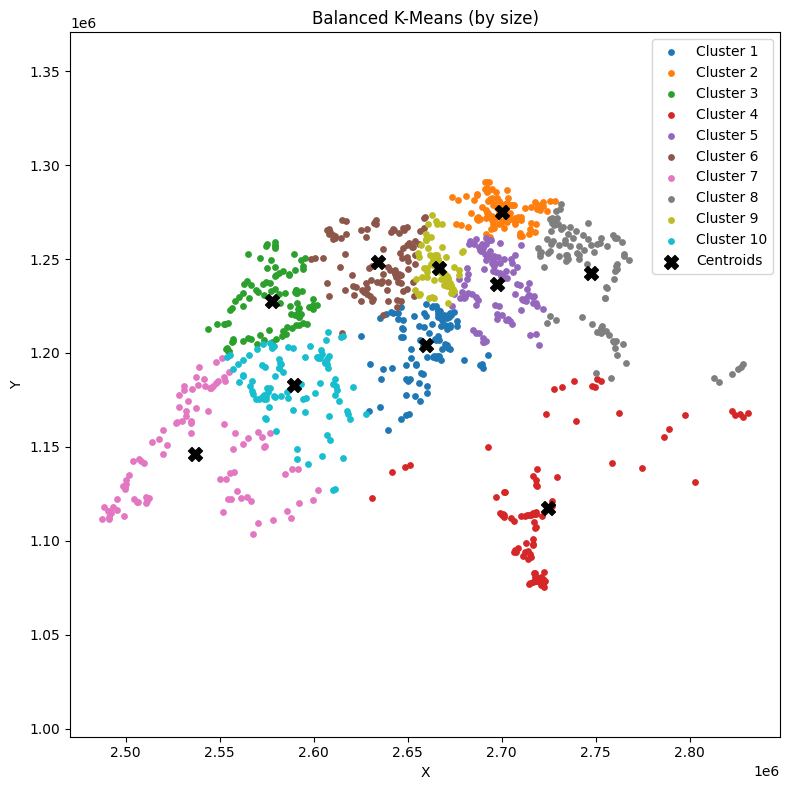

|   Cluster |   Size |   Sum of Probs |
|-----------|--------|----------------|
|         1 |     96 |          1.026 |
|         2 |     96 |          0.558 |
|         3 |     96 |          1.664 |
|         4 |     95 |          0.357 |
|         5 |     96 |          0.586 |
|         6 |     96 |          1.274 |
|         7 |     96 |          1.885 |
|         8 |     96 |          0.155 |
|         9 |     96 |          0.939 |
|        10 |     96 |          1.572 |


In [38]:
import numpy as np
import matplotlib.pyplot as plt

from k_means_constrained import KMeansConstrained

# -- Your `coords` and `probs` here --

n_clusters = n

# Set almost equal size per cluster
cluster_size = len(coords) // n_clusters

kmeans = KMeansConstrained(
    n_clusters=n_clusters,
    size_min=cluster_size,
    size_max=cluster_size+1,  # Allow one extra point for rounding
    random_state=42
)
cluster_labels = kmeans.fit_predict(coords)

# Calculate cluster sizes and prob sums
cluster_sizes = np.zeros(n_clusters, dtype=int)
cluster_prob_sums = np.zeros(n_clusters, dtype=float)

for i in range(n_clusters):
    idx = (cluster_labels == i)
    cluster_sizes[i] = np.sum(idx)         # Number of points in cluster i
    cluster_prob_sums[i] = np.sum(probs[idx])  # Sum of probs for cluster i

# Plot as before
plt.figure(figsize=(8, 8))
for i in range(n_clusters):
    idx = cluster_labels == i
    plt.scatter(coords[idx, 0], coords[idx, 1], label=f'Cluster {i+1}', s=15)
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', s=100, marker='X', label='Centroids')
plt.legend()
plt.title('Balanced K-Means (by size)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Tabular display
from tabulate import tabulate

header = ["Cluster", "Size", "Sum of Probs"]
data = [
    [i+1, cluster_sizes[i], f"{cluster_prob_sums[i]:.4f}"] 
    for i in range(n_clusters)
]
print(tabulate(data, headers=header, tablefmt="github"))

|   Cluster |   Unique Size |   Sum of Probs |
|-----------|---------------|----------------|
|         1 |            73 |          1.009 |
|         2 |            49 |          1.008 |
|         3 |           225 |          1     |
|         4 |           106 |          0.997 |
|         5 |            52 |          0.999 |
|         6 |           180 |          1.003 |
|         7 |            58 |          0.991 |
|         8 |            95 |          1.002 |
|         9 |            63 |          1.003 |
|        10 |            58 |          1.004 |


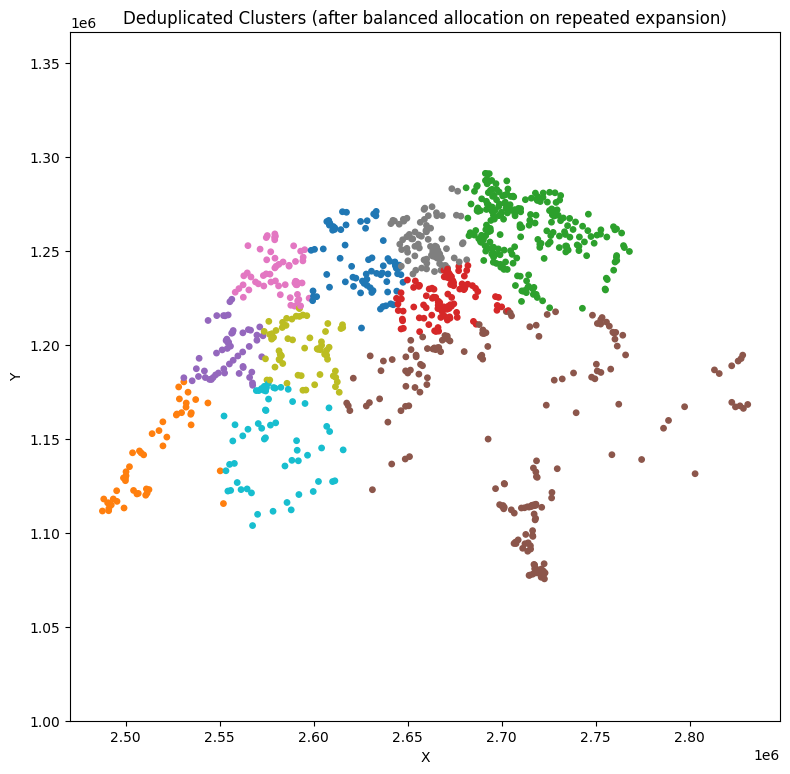

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from k_means_constrained import KMeansConstrained
from tabulate import tabulate

# Example setup -- replace with your coords/probs loading!
# coords = ...
# probs = ...

n_clusters = n


# 1. Convert probs to integer counts
counts = (probs / q).round().astype(int)

# 2. Replicate coordinates according to counts
expanded_coords = np.repeat(coords, counts, axis=0)
expanded_idx = np.repeat(np.arange(len(coords)), counts)
# expanded_idx maps each expanded row to its original coord/probs index

# 3. Size-balanced clustering on the expanded population
cluster_size = len(expanded_coords) // n_clusters
kmeans = KMeansConstrained(
    n_clusters=n_clusters,
    size_min=cluster_size,
    size_max=cluster_size+1,
    random_state=42
)
cluster_labels = kmeans.fit_predict(expanded_coords)

# 4. Assign clusters to original coordinates by majority/first assignment
# For each original coordinate, get the set of clusters its copies were assigned to, pick the most common
from scipy.stats import mode
unique_clusters = np.zeros(len(coords), dtype=int)
for i in range(len(coords)):
    assigned_labels = cluster_labels[expanded_idx == i]
    # Use majority cluster assignment; if tie, choose the smallest label
    if len(assigned_labels) > 0:
        unique_clusters[i] = mode(assigned_labels, keepdims=True)[0][0]
    else:
        unique_clusters[i] = -1  # Just in case

# 5. For each cluster: count unique units and sum probs
cluster_sizes = np.zeros(n_clusters, dtype=int)
cluster_prob_sums = np.zeros(n_clusters, dtype=float)
for i in range(n_clusters):
    mask = (unique_clusters == i)
    cluster_sizes[i] = np.sum(mask)
    cluster_prob_sums[i] = np.sum(probs[mask])

# 6. Results Table
header = ["Cluster", "Unique Size", "Sum of Probs"]
data = [
    [i+1, cluster_sizes[i], f"{cluster_prob_sums[i]:.4f}"]
    for i in range(n_clusters)
]
print(tabulate(data, headers=header, tablefmt="github"))

# 7. Optional: Plot
plt.figure(figsize=(8, 8))
colors = plt.cm.Set1(unique_clusters / n_clusters)
plt.scatter(coords[:, 0], coords[:, 1], c=unique_clusters, cmap='tab10', s=15)
plt.title('Deduplicated Clusters (after balanced allocation on repeated expansion)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.tight_layout()
plt.show()